# 2D wave equation, direct problem
---

Consider the 2d wave
$$
u_{tt} = c^2(u_{xx} + u_{yy}), \ (x, y, t) \in [0, 1]\times [0, 1]\times [0, 1] 
$$
with ic and bc
$$
u(x, y, 0) = \sin(p\pi x)\sin(q\pi y), \ u(0, y, t) = u(1, y, t) = u(x, 0, t) = u(x, 1, t) = 0.
$$
Parameters:
$$
c = 1, p = 2, q = 1.
$$

The analytic solution:
$$
u(x, y, t) = \sin(p\pi x)\sin(q\pi y)\cos\left(c\pi t\sqrt{p^2+q^2}\right).
$$

In [15]:
NAME = "1"

In [16]:
import jax, jax.nn
from jax import random
import jax.numpy as jnp
from jax.experimental import optimizers

import sys, os
sys.path.append("../../")
	
from Seismic_wave_inversion_PINN.data_utils import *

from collections import namedtuple

In [17]:
def siren_layer_params(key, scale, m, n):
	w_key, b_key = random.split(key)
	return random.uniform(w_key, (m, n), jnp.float32, minval = -scale, maxval = scale), jnp.zeros((n, ), jnp.float32)

def init_siren_params(key, layers, c0, w0):
	keys = random.split(key, len(layers))
	return [siren_layer_params(keys[0], w0*jnp.sqrt(c0/layers[0]), layers[0], layers[1])] + \
			[siren_layer_params(k, jnp.sqrt(c0/m), m, n) for m, n, k in zip(layers[1:-1], layers[2:], keys[1:])]

layers = [3, 128, 128, 128, 128, 128, 1] # (x, z, t) -> p
c0 = 1.0
w0 = 10.0
lambda_0 = 1e-10
direct_params = init_siren_params(random.PRNGKey(0), layers, c0, w0)

@jax.jit
def scalar_direct_model(params, x, z, t):
	x_ = jnp.hstack([x, z, t])
	for w, b in params[:-1]:
		x_ = jnp.sin(jnp.dot(x_, w) + b)
	return jnp.sum(jnp.dot(x_, params[-1][0]) + params[-1][1])

direct_model = jax.jit(jax.vmap(scalar_direct_model, in_axes = (None, 0, 0, 0)))

In [18]:
c = 1
p = 2
q = 1
domain = [0, 1]
T_max = 1

u_fn = lambda x, y, t: np.sin(p*np.pi*x)*np.sin(q*np.pi*y)*np.cos(c*np.pi*np.sqrt(p**2+q**2)*t)

In [19]:
@jax.jit
def mse(pred, true):
	return jnp.mean(jnp.square(pred - true))

@jax.jit
def l2_regularization(params, lambda_0):
	res = 0
	for p in params:
		res += jnp.sum(jnp.square(p[0]))
	return res*lambda_0

@jax.jit
def scalar_du_dx(params, x, y, t):
    return jnp.sum(jax.grad(scalar_direct_model, 1)(params, x, y, t))

@jax.jit
def scalar_du_dy(params, x, y, t):
    return jnp.sum(jax.grad(scalar_direct_model, 2)(params, x, y, t))

@jax.jit
def scalar_du_dt(params, x, y, t):
    return jnp.sum(jax.grad(scalar_direct_model, 3)(params, x, y, t))

@jax.jit
def du_dxx(params, x, y, t):
    return jax.grad(scalar_du_dx, 1)(params, x, y, t)

@jax.jit
def du_dyy(params, x, y, t):
    return jax.grad(scalar_du_dy, 2)(params, x, y, t)

@jax.jit
def du_dtt(params, x, y, t):
    return jax.grad(scalar_du_dt, 3)(params, x, y, t)

@jax.jit
def loss_fn_(params, batch):
	collocation, dirichlet = batch["collocation"], batch["dirichlet"]
	direct_params = params
    
	du_dtt_ = du_dtt(direct_params, collocation.x, collocation.y, collocation.t)
	du_dxx_ = du_dxx(direct_params, collocation.x, collocation.y, collocation.t)
	du_dyy_ = du_dyy(direct_params, collocation.x, collocation.y, collocation.t)
	u_pred = direct_model(direct_params, dirichlet.x, dirichlet.y, dirichlet.t).reshape((-1, 1))
	
	loss_c = mse(du_dtt_ - c**2*(du_dxx_ + du_dyy_), 0)
	loss_d = mse(u_pred, dirichlet.u)
	return loss_c, loss_d

@jax.jit
def loss_fn(params, batch):
	loss_c, loss_d = loss_fn_(params, batch)
	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d + l2_regularization(params[0], lambda_0)

@jax.jit
def step(i, opt_state, batch):
	params = get_params(opt_state)
	grad = jax.grad(loss_fn, 0)(params, batch)
	return opt_update(i, grad, opt_state)

@jax.jit
def evaluate(params, batch):
	loss_c, loss_d = loss_fn_(params, batch)
	return batch["weights"]["c"]*loss_c + batch["weights"]["d"]*loss_d, loss_c, loss_d


In [20]:
key = random.PRNGKey(1)

# ic
key, *subkeys = random.split(key, 4)
n_i = 1000
x_i = random.uniform(subkeys[0], (n_i, 1), np.float32, minval = domain[0], maxval = domain[1])
y_i = random.uniform(subkeys[1], (n_i, 1), np.float32, minval = domain[0], maxval = domain[1])
t_i = jnp.zeros_like(x_i)
u_i = u_fn(x_i, y_i, t_i)

# bc
key, *subkeys = random.split(key, 4)
n_b = 200
x_b = random.uniform(subkeys[0], (n_b, 1), np.float32, minval = domain[0], maxval = domain[1])
y_b = random.uniform(subkeys[1], (n_b, 1), np.float32, minval = domain[0], maxval = domain[1])
x_b = jnp.vstack([x_b, jnp.ones((n_b, 1))*domain[1], x_b, jnp.ones((n_b, 1))*domain[0]])
y_b = jnp.vstack([jnp.ones((n_b, 1))*domain[0], y_b, jnp.ones((n_b, 1))*domain[1], y_b])
t_b = random.uniform(subkeys[2], (n_b*4, 1), np.float32, minval = 0, maxval = T_max)
u_b = u_fn(x_b, y_b, t_b)

# c
n_c = 50
x_c = jnp.linspace(*domain, n_c)
y_c = jnp.linspace(*domain, n_c)
t_c = jnp.linspace(0, T_max, n_c)
txy_c = tensor_grid([t_c, x_c, y_c])

dataset_Dirichlet = namedtuple("dataset_Dirichlet", ["x", "y", "t", "u"])
dataset_Collocation = namedtuple("dataset_Collocation", ["x", "y", "t"])
dirichlet = dataset_Dirichlet(*map(lambda x: jnp.array(x), [jnp.vstack([x_i, x_b]), jnp.vstack([y_i, y_b]),
															jnp.vstack([t_i, t_b]), jnp.vstack([u_i, u_b])]))
collocation = dataset_Collocation(*map(lambda x: jnp.array(x), [jnp.vstack([txy_c[:, 1:2], dirichlet.x]),
																jnp.vstack([txy_c[:, 2:3], dirichlet.y]), 
																jnp.vstack([txy_c[:, 0:1], dirichlet.t])]))

class Batch_Generator:
	def __init__(self, key, dataset, batch_size):
		self.key = key
		self.dataset = dataset
		self.batch_size = batch_size
		self.index = jnp.arange(dataset[0].shape[0])
		self.pointer = 0
		self._shuffle()
		
	def _shuffle(self):
		key, subkey = random.split(self.key)
		self.index = random.permutation(subkey, jnp.arange(self.dataset[0].shape[0]))
		self.key = key
		
	def __iter__(self):
		return self
	
	def __next__(self):
		if self.pointer >= len(self.index):
			self._shuffle()
			self.pointer = 0
		self.pointer += self.batch_size
		index_ = self.index[self.pointer-self.batch_size:self.pointer]
		return [d[index_, :] for d in self.dataset]

In [21]:
lr = 1e-4
start_iteration = 0
iterations = 50000
print_every = 1000
save_every = 50000
batch_size_collocation = 10000
batch_size_dirichlet = 10000
w_c = 1.0
w_d = 100.0

key, *subkeys = random.split(key, 3)

Dirichlet = Batch_Generator(subkeys[0], dirichlet, batch_size_dirichlet)
Collocation = Batch_Generator(subkeys[1], collocation, batch_size_collocation)
params = direct_params

opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(params)
for iteration in range(start_iteration+1, start_iteration+iterations+1):
	batch = {
		"dirichlet": dataset_Dirichlet(*next(Dirichlet)),
		"collocation": dataset_Collocation(*next(Collocation)),
		"weights": {"c": w_c, "d": w_d}
	}
	opt_state = step(iteration, opt_state, batch)
	if (iteration-start_iteration) % print_every == 0:
		names = ["Loss", "c", "d"]
		params_ = get_params(opt_state)
		losses = evaluate(params_, batch)
		print("{}, Iteration: {}, Train".format(get_time(), iteration) + \
			  ','.join([" {}: {:.4e}".format(name, loss) for name, loss in zip(names, losses)]))
	if (iteration-start_iteration) % save_every == 0:
		params_ = np.asarray(get_params(opt_state), dtype = object)
		save_path = "models/{}/iteration_{}/params.npy".format(NAME, iteration)
		if not os.path.exists(os.path.dirname(save_path)):
			os.makedirs(os.path.dirname(save_path))
		np.save(save_path, params_)

2020/07/29, 23:44:46, Iteration: 1000, Train Loss: 9.3802e-02, c: 4.2045e-02, d: 5.1757e-04
2020/07/29, 23:45:07, Iteration: 2000, Train Loss: 3.3365e-02, c: 1.7727e-02, d: 1.5638e-04
2020/07/29, 23:45:28, Iteration: 3000, Train Loss: 1.8818e-02, c: 1.0087e-02, d: 8.7307e-05
2020/07/29, 23:45:48, Iteration: 4000, Train Loss: 1.4389e-02, c: 8.1862e-03, d: 6.2030e-05
2020/07/29, 23:46:09, Iteration: 5000, Train Loss: 1.4867e-02, c: 9.4706e-03, d: 5.3965e-05
2020/07/29, 23:46:29, Iteration: 6000, Train Loss: 9.0048e-03, c: 5.3566e-03, d: 3.6482e-05
2020/07/29, 23:46:50, Iteration: 7000, Train Loss: 6.7928e-03, c: 3.9010e-03, d: 2.8918e-05
2020/07/29, 23:47:12, Iteration: 8000, Train Loss: 8.7997e-03, c: 6.2171e-03, d: 2.5826e-05
2020/07/29, 23:47:32, Iteration: 9000, Train Loss: 9.3084e-03, c: 6.4981e-03, d: 2.8103e-05
2020/07/29, 23:47:53, Iteration: 10000, Train Loss: 5.0008e-03, c: 2.9497e-03, d: 2.0511e-05
2020/07/29, 23:48:14, Iteration: 11000, Train Loss: 8.4443e-03, c: 5.8890e-03, 

In [22]:
import matplotlib as mpl
from matplotlib.cm import cool
from matplotlib.colors import Normalize

from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import pyplot as plt
plt.rcParams.update(plt.rcParamsDefault)

def plot_(t_index):
	txy_test = tensor_grid([t_c[t_index], x_c, y_c])
	u_pred = direct_model(get_params(opt_state), txy_test[:, 1:2], txy_test[:, 2:3], txy_test[:, 0:1]).reshape((n_c, n_c))
	u_true = u_fn(txy_test[:, 1:2], txy_test[:, 2:3], txy_test[:, 0:1]).reshape((n_c, n_c))

	cmap = cool
	norm = Normalize(vmin=-0.5, vmax=0.5)

	X, Y = np.meshgrid(x_c, y_c)
	fig, ax = plt.subplots(1, 3, figsize = (15, 5))
	fig.subplots_adjust(right = 1.0)

	im0 = ax[0].contourf(X, Y, u_true, cmap = cmap, norm = norm, levels = 1000)
	ax[0].set_title("true")
	divider = make_axes_locatable(ax[0])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	# norm = mpl.colors.Normalize(vmin=1.0, vmax=3.0)
	im1 = ax[1].contourf(X, Y, u_pred, cmap = cmap, norm = norm, levels = 1000)
	ax[1].set_title("pred")
	ax[1].set_xlabel("")
	divider = make_axes_locatable(ax[1])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	norm = mpl.colors.Normalize(vmin=-0.2, vmax=0.2)
	im2 = ax[2].contourf(X, Y, u_true - u_pred, cmap = cmap, norm = norm, levels = 1000)
	ax[2].set_title("t = {:.4e}, MSE: {}".format(t_c[t_index], np.mean(np.square(u_true - u_pred))))
	divider = make_axes_locatable(ax[2])
	cax = divider.append_axes('right', size='5%', pad=0.05)
	mpl.colorbar.ColorbarBase(cax, cmap = cmap, norm = norm, orientation='vertical')

	plt.show()

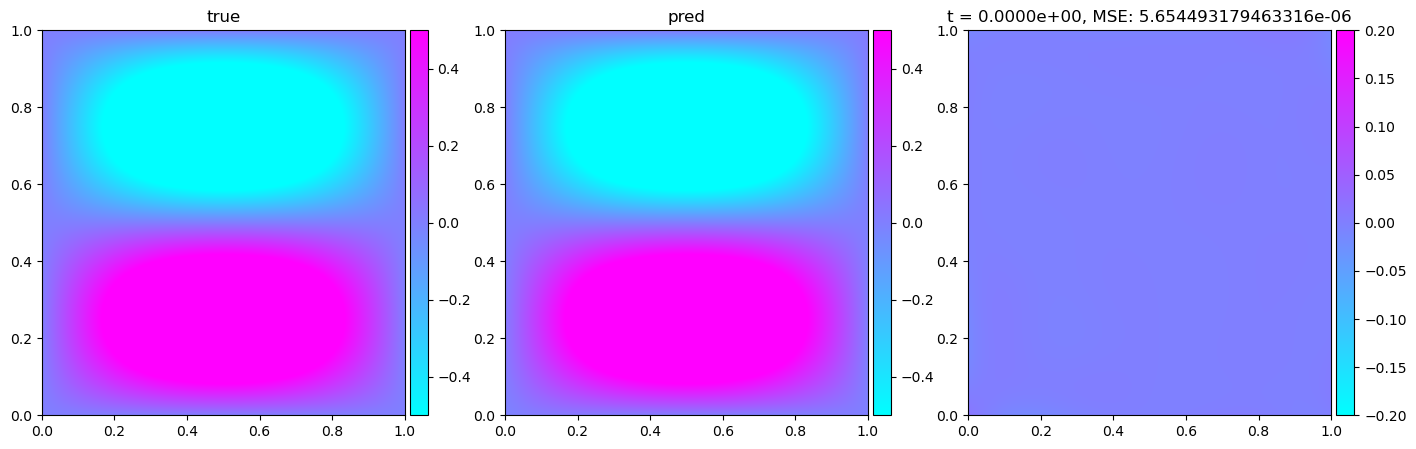

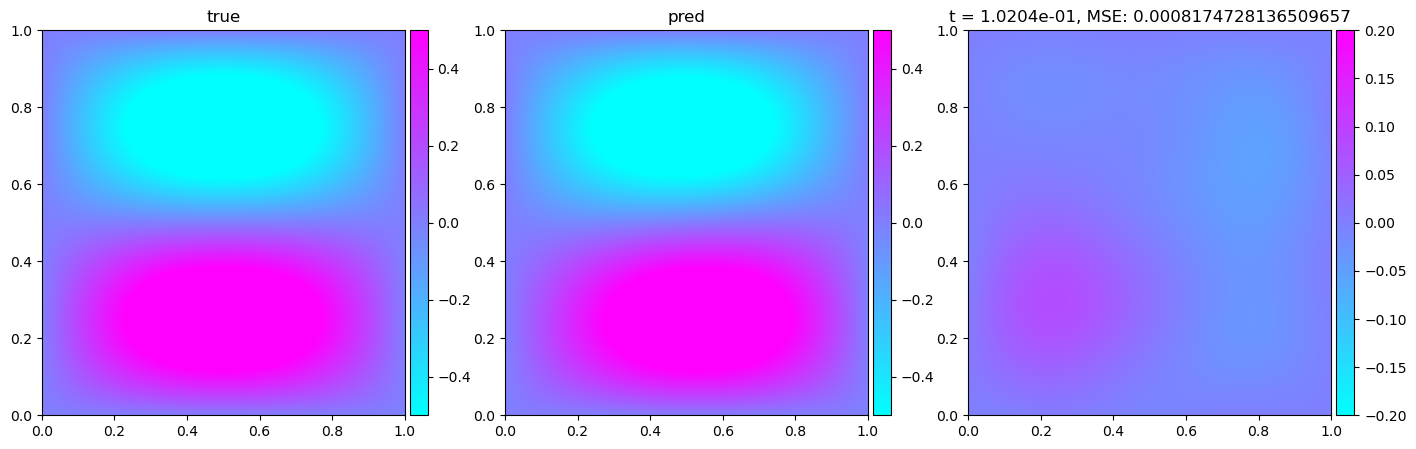

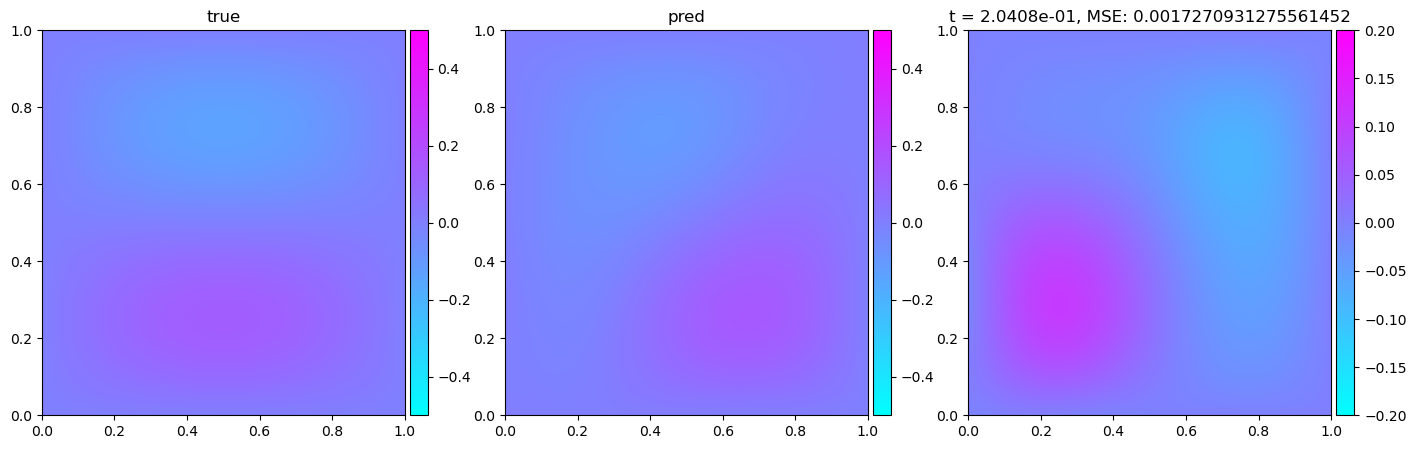

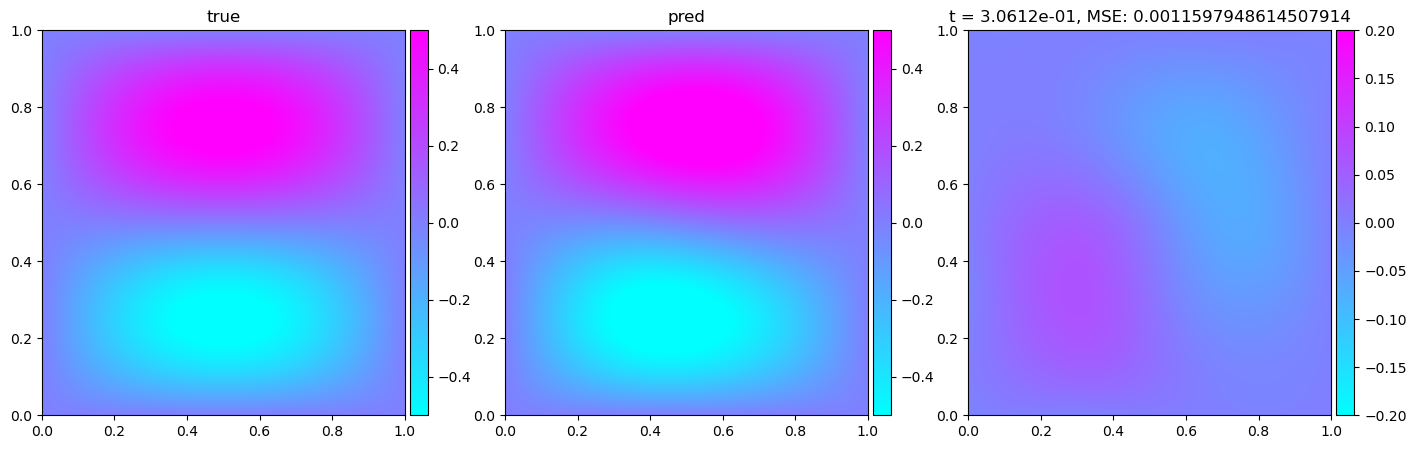

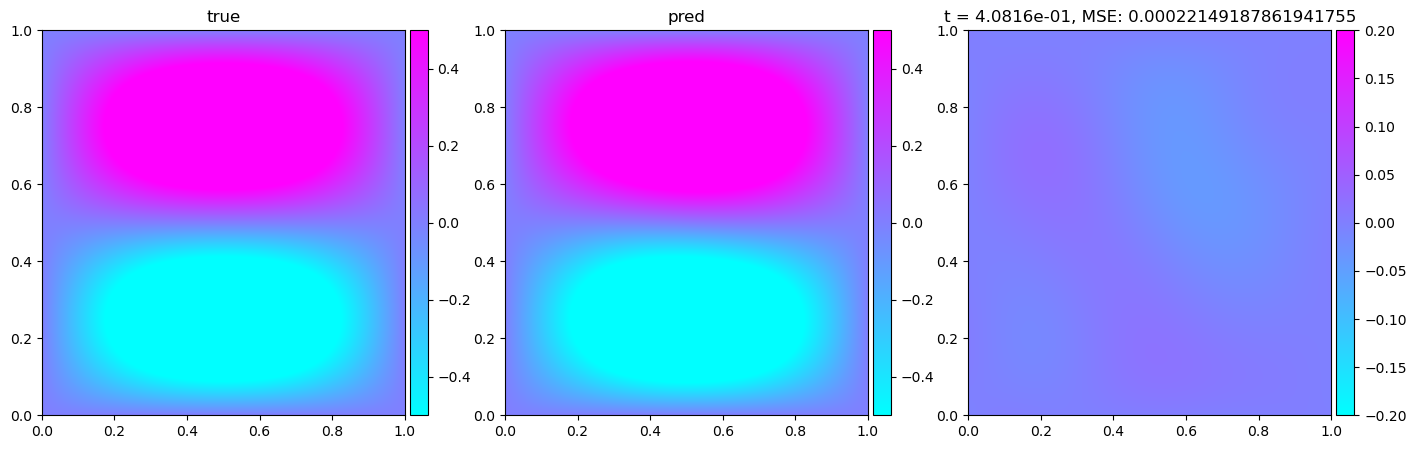

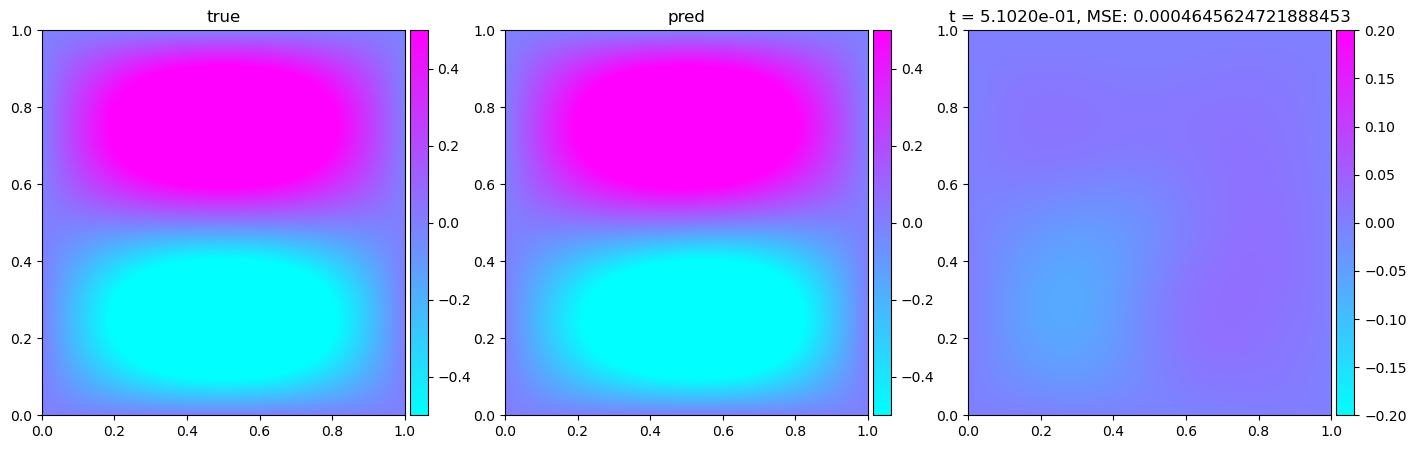

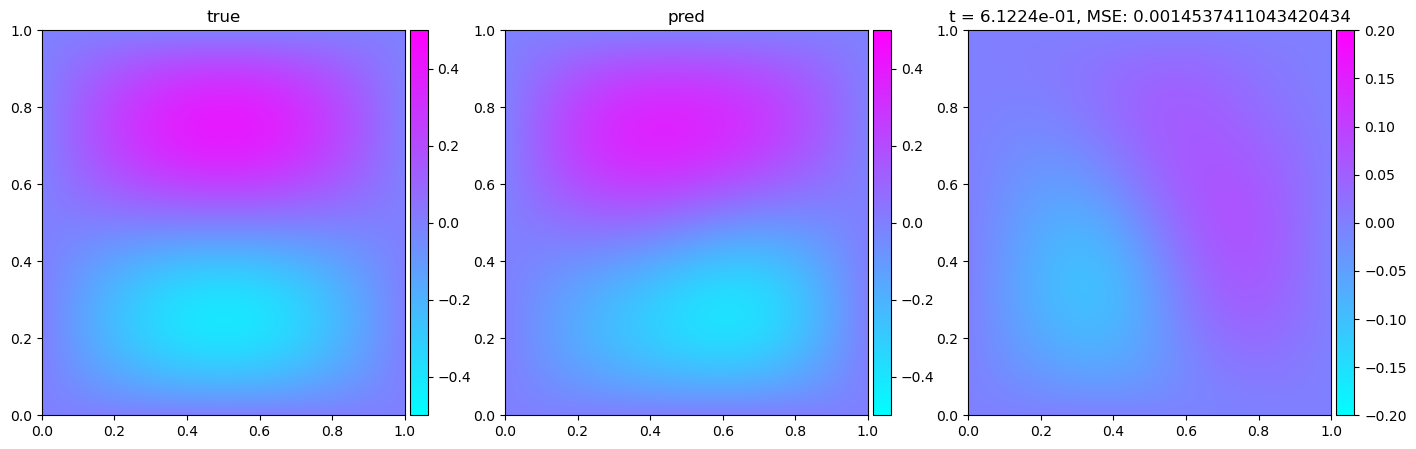

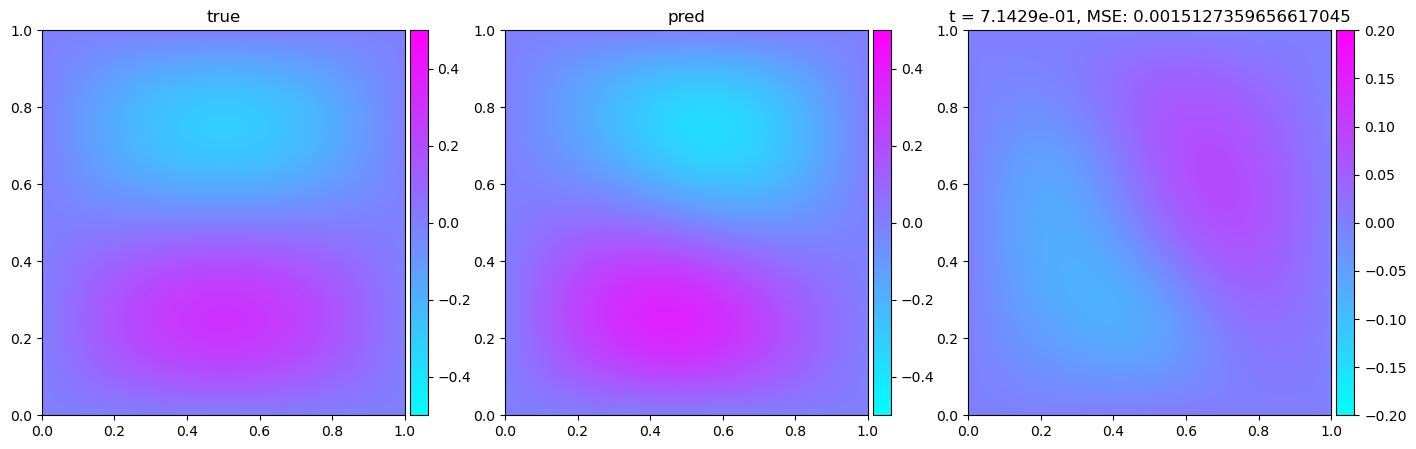

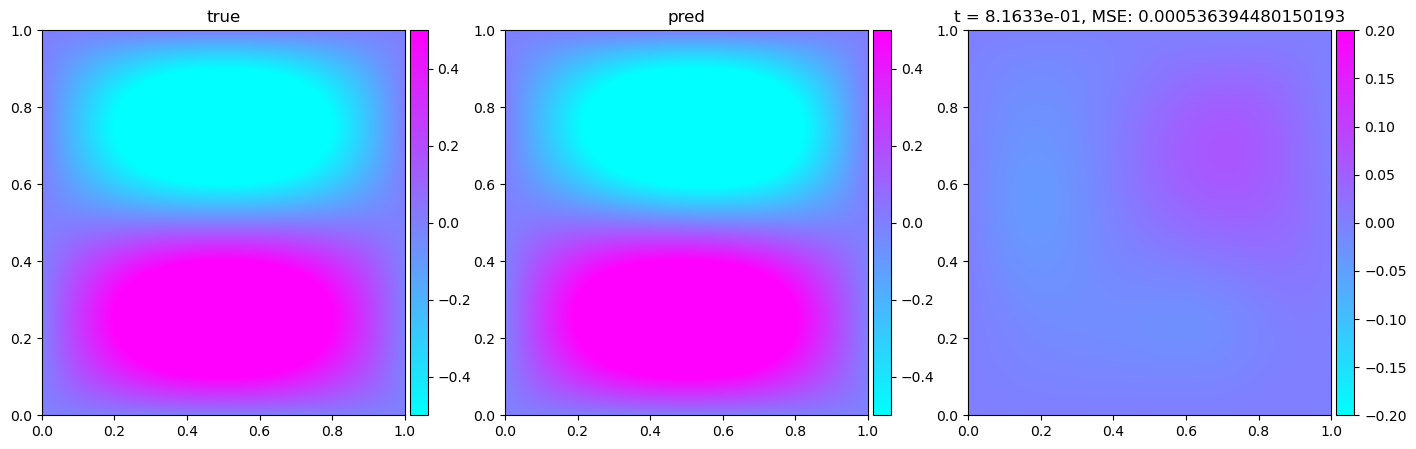

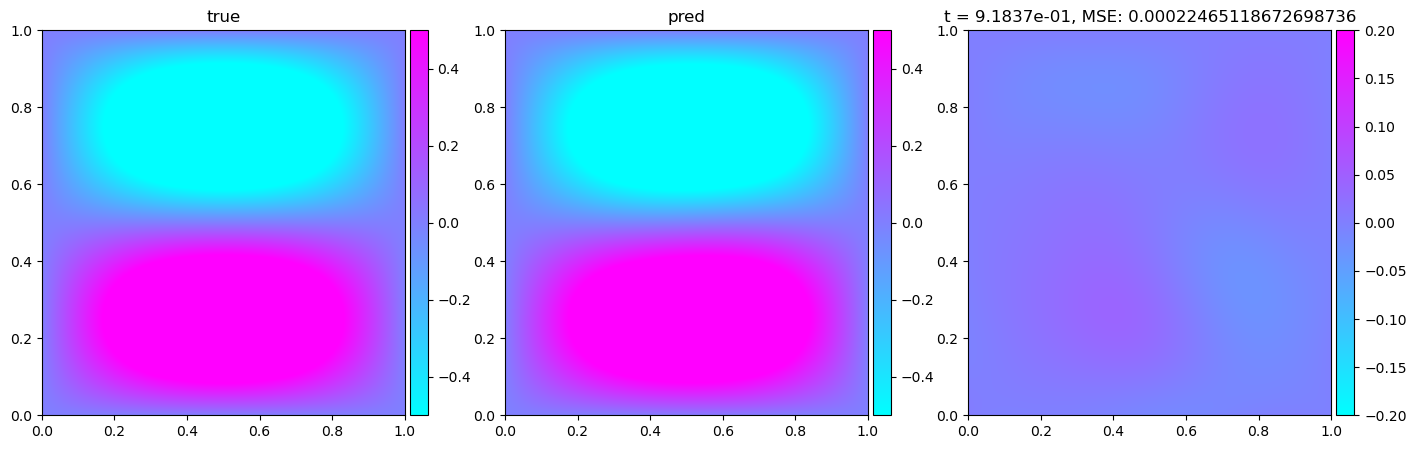

In [23]:
for i in range(0, 50, 5):
	plot_(i)

In [9]:
# 2020/07/29, 16:58:35, Iteration: 100, Train Loss: 3.0162e+06, c: 3.0162e+06, d: 2.7081e-01
# 2020/07/29, 16:59:07, Iteration: 100, Train Loss: 3.0162e+06, c: 3.0162e+06, d: 2.7081e-01
# 2020/07/29, 16:59:42, Iteration: 100, Train Loss: 3.0162e+06, c: 3.0162e+06, d: 2.7081e-01
# 2020/07/29, 17:00:56, Iteration: 100, Train Loss: 3.0162e+06, c: 3.0162e+06, d: 2.7081e-01